In [1]:
import utils
from utils.parcel import get_parcel_obj_list
import utils.synthetic as v2

import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.cm
from shapely.ops import cascaded_union
from shapely.affinity import scale
from shapely.geometry import MultiPolygon


In /home/rohana/anaconda2/envs/geoGT/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/rohana/anaconda2/envs/geoGT/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/rohana/anaconda2/envs/geoGT/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /home/rohana/anaconda2/envs/geoGT/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/rohana/

## Synthetic City Construction

In [2]:
def add_noise(grid, noise_std, verbose=False):
    for block in grid.blocks:
        for side in range(4):
            if side % 2 == 0:
                x_noise = np.random.normal(1, noise_std)
                y_noise = 1
            else:
                x_noise = 1
                y_noise = np.random.normal(1, noise_std)
            if verbose: print(side, x_noise, y_noise)
            block.scale(x_noise, y_noise, origin=2)
    grid.update()


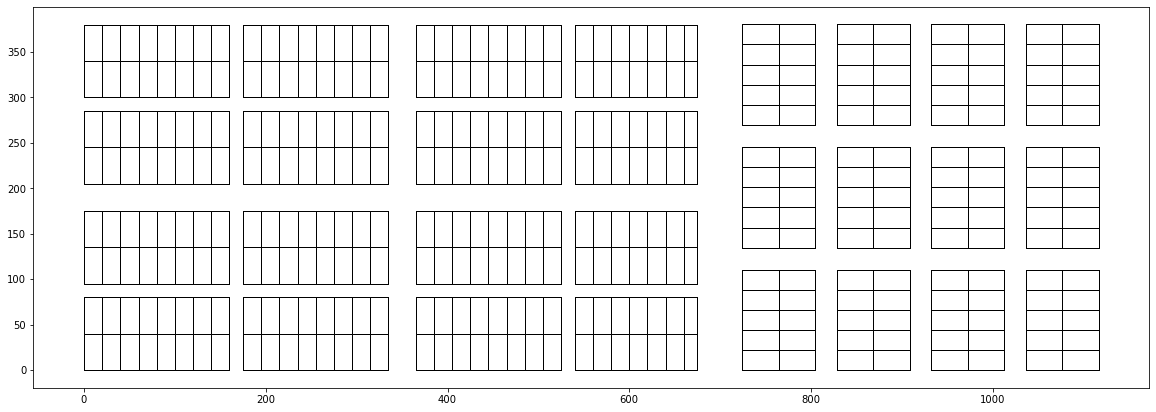

In [3]:
fig, ax = plt.subplots(figsize=(20,10))

mg_size = 2
i_road = 15
i_blockw = 160
i_blockh = 80
mg_road = 30

x_offset = 160 * mg_size + i_road * (mg_size-1) + mg_road
y_offset = 80 * mg_size + i_road * (mg_size-1) + mg_road

mg = v2.grid_block_map(grid_h=mg_size, grid_w=mg_size, vert_road_w=i_road, horz_road_w=i_road, block_w=i_blockw, block_h=i_blockh)

mg01 = v2.grid_block_map(grid_h=mg_size, grid_w=mg_size, vert_road_w=i_road, horz_road_w=i_road, block_w=i_blockw, block_h=i_blockh)
mg01.translate(0, y_offset)
mg.merge_with_map(mg01, 0, 0, 0)

mg10 = v2.grid_block_map(grid_h=mg_size, grid_w=mg_size, vert_road_w=i_road, horz_road_w=i_road, block_w=i_blockw, block_h=i_blockh)
mg10.translate(x_offset, 0)
mg.merge_with_map(mg10, 0, 0, 0)

mg11 = v2.grid_block_map(grid_h=mg_size, grid_w=mg_size, vert_road_w=i_road, horz_road_w=i_road, block_w=i_blockw, block_h=i_blockh)
mg11.translate(x_offset, y_offset)
mg.merge_with_map(mg11, 0, 0, 0)

og = v2.grid_block_map(grid_h=4, grid_w=3, vert_road_w=24, horz_road_w=24, block_w=111)
og.rotate(90)
mg.merge_with_map(og, 50, x_offset * 2, -6, 100)

v2.plot_polygon(mg.parcels, ax=ax)

<AxesSubplot:>

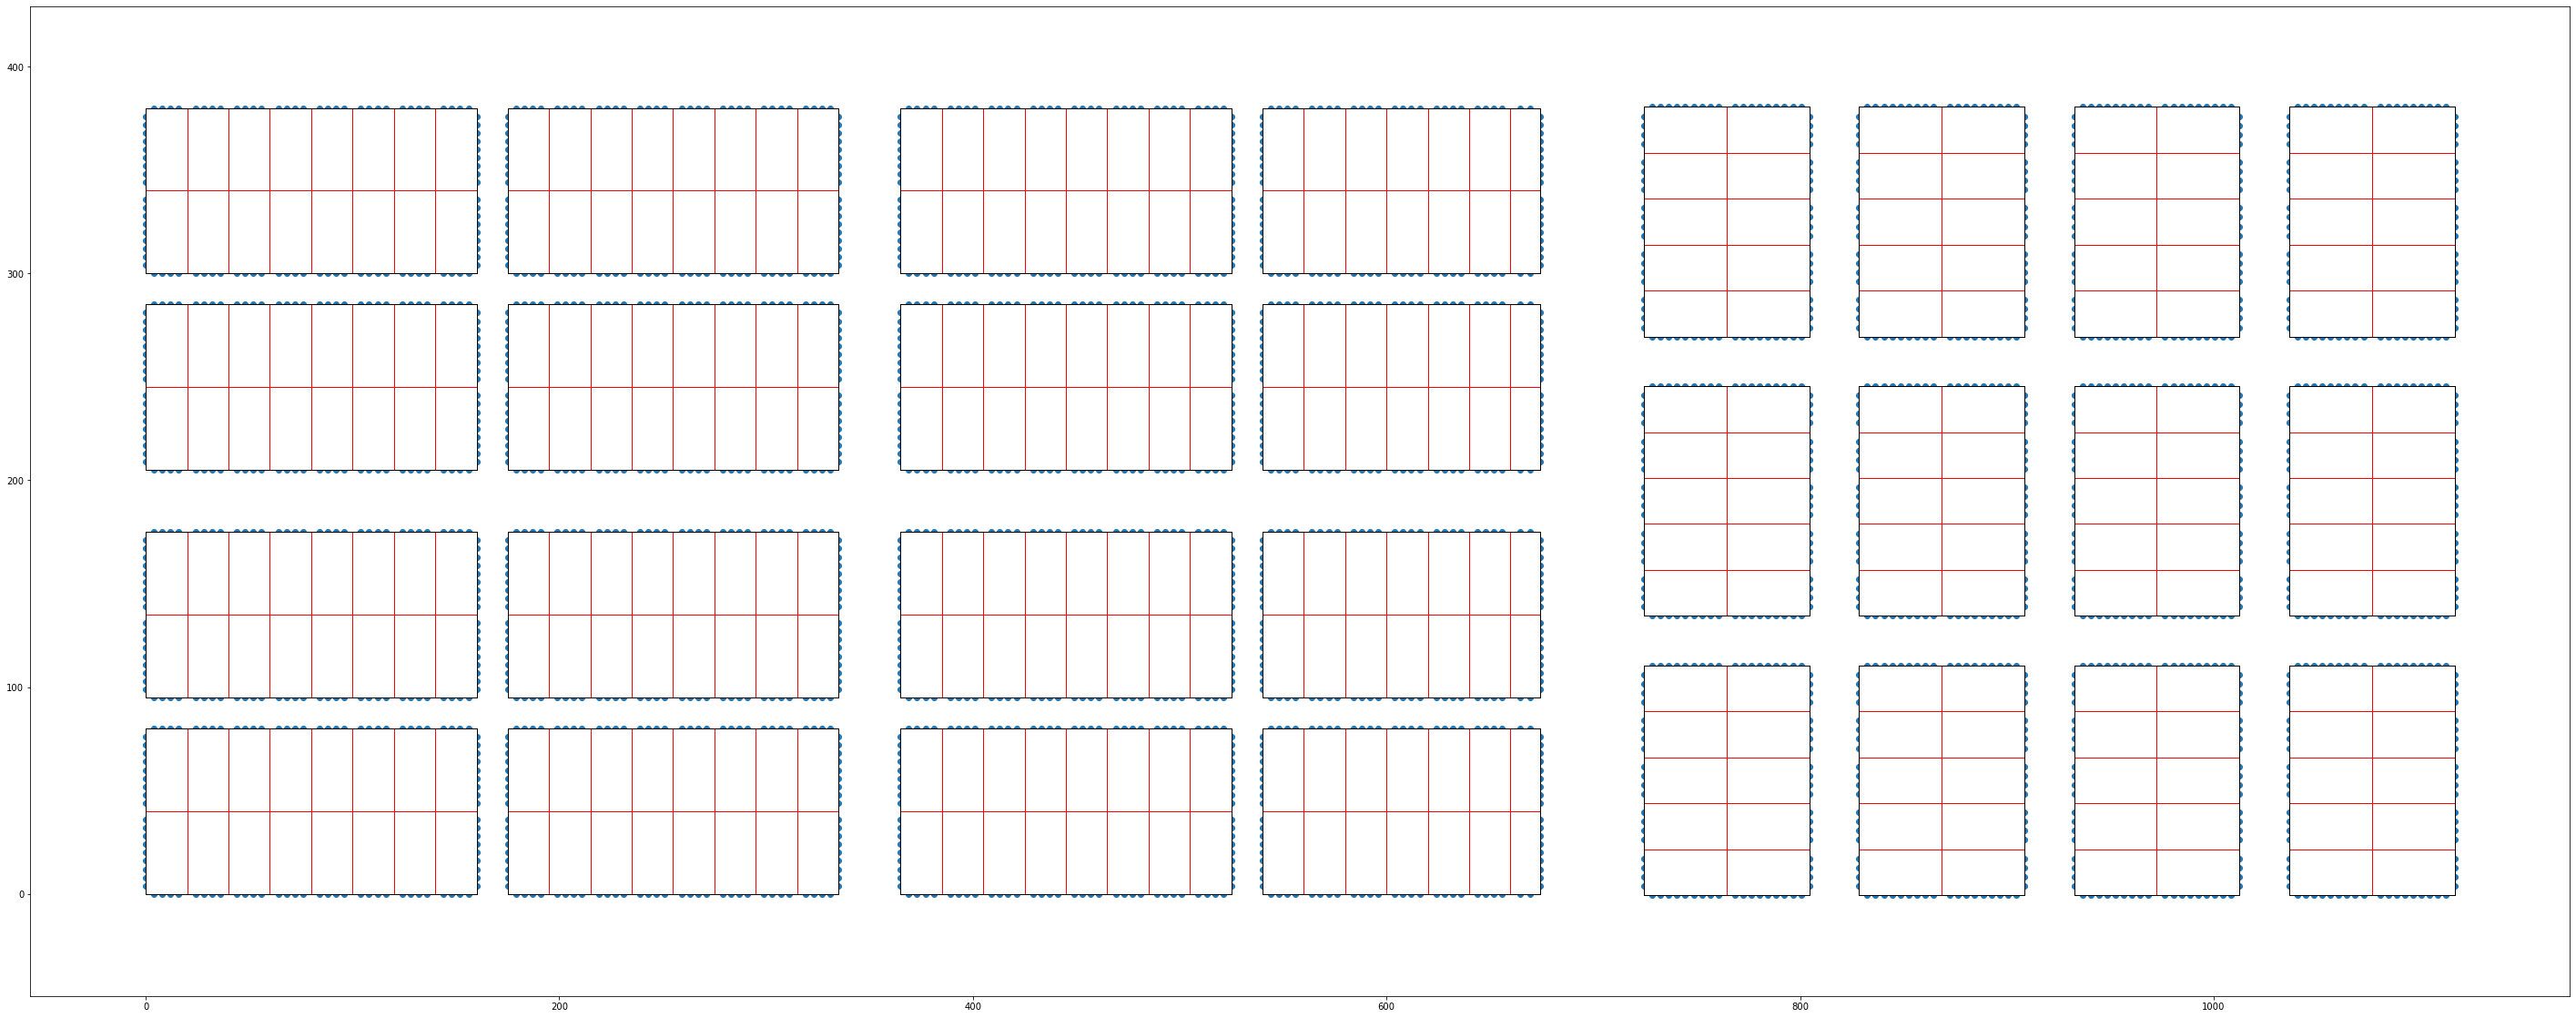

In [4]:
blocks = cascaded_union(mg.parcels)

parcel_objs = get_parcel_obj_list(pd.Series(list(mg.parcels)), blocks, None, min_dist=4)

f, ax = plt.subplots(figsize=(50, 20))
ax.axis('equal')
gpd.GeoSeries(parcel_objs.apply(lambda x: list(x[0])[0], axis=1)).plot(ax=ax)
gpd.GeoSeries(list(mg.parcels)).plot(ax=ax, color='white', edgecolor='red')
gpd.GeoDataFrame({'parcels': blocks}, geometry='parcels').plot(ax=ax, facecolor='none', edgecolor='black')

In [5]:
Z = utils.polygon_based.cluster_finder([p.polygon for p in parcel_objs.parcels])

In [6]:
cluster = utils.polygon_based.cluster_wrapper(Z, parcel_objs.parcels, discretize=True)

0


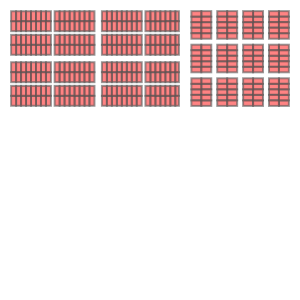

In [7]:
MultiPolygon([p.polygon for p in cluster.parcels])

## Synthetic City Analysis Without Noise

(-55.825, 1172.325, -19.55, 399.55)

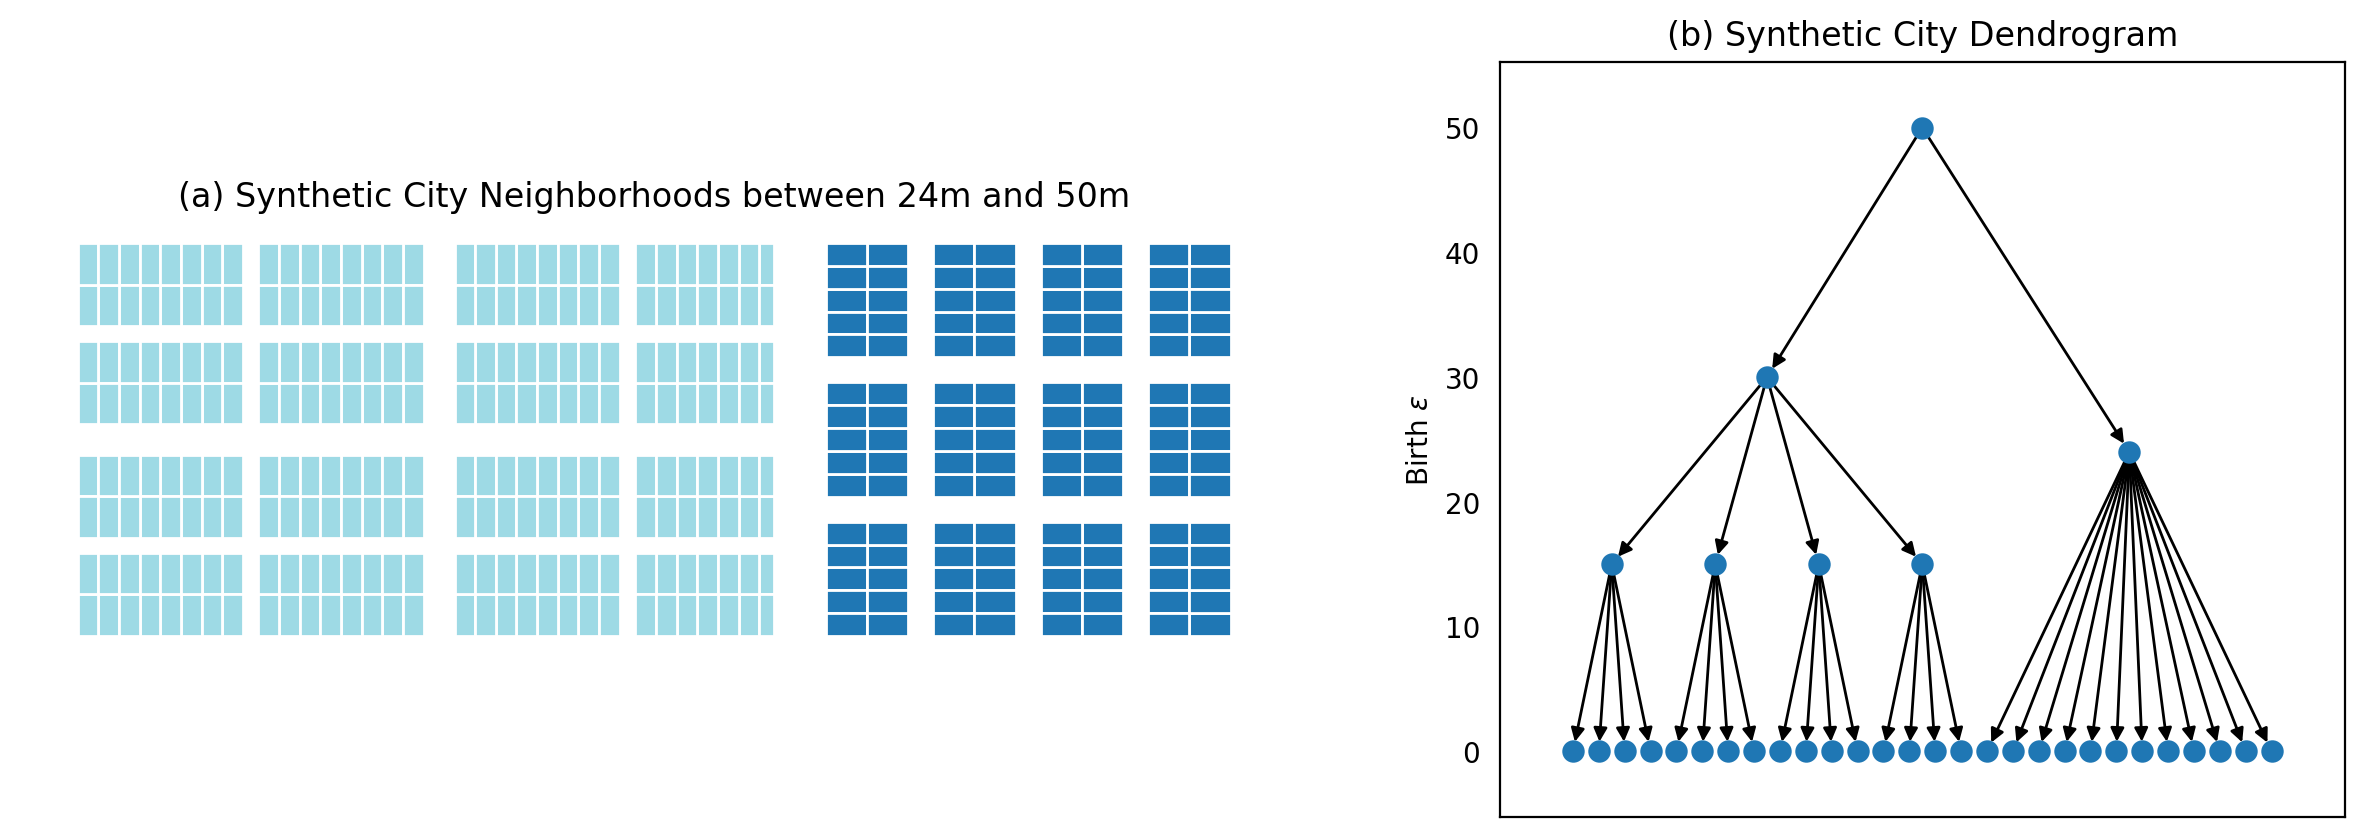

In [8]:
import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")

    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5), dpi=200, gridspec_kw={'width_ratios': [3, 2]})
    utils.plot_dendrogram(cluster, ax=ax2, node_color="tab:blue", width=1, node_size=50)
    ax2.set_title('(b) Synthetic City Dendrogram')
    
plot_data = {'geometry': [], 'cluster_number': []}
for i, sc in enumerate(utils.get_exists_at(cluster, 48)):
    plot_data['geometry'].extend([parcel.polygon for parcel in sc.parcels])
    plot_data['cluster_number'].extend([i % 20] * len(sc.parcels))
gpd.GeoDataFrame(plot_data).plot(ax=ax1, column='cluster_number', edgecolor='white', cmap='tab20')
ax1.set_title('(a) Synthetic City Neighborhoods between 24m and 50m')
ax1.axis('off')

(-55.825, 1172.325, -109.11395161290321, 489.1139516129033)

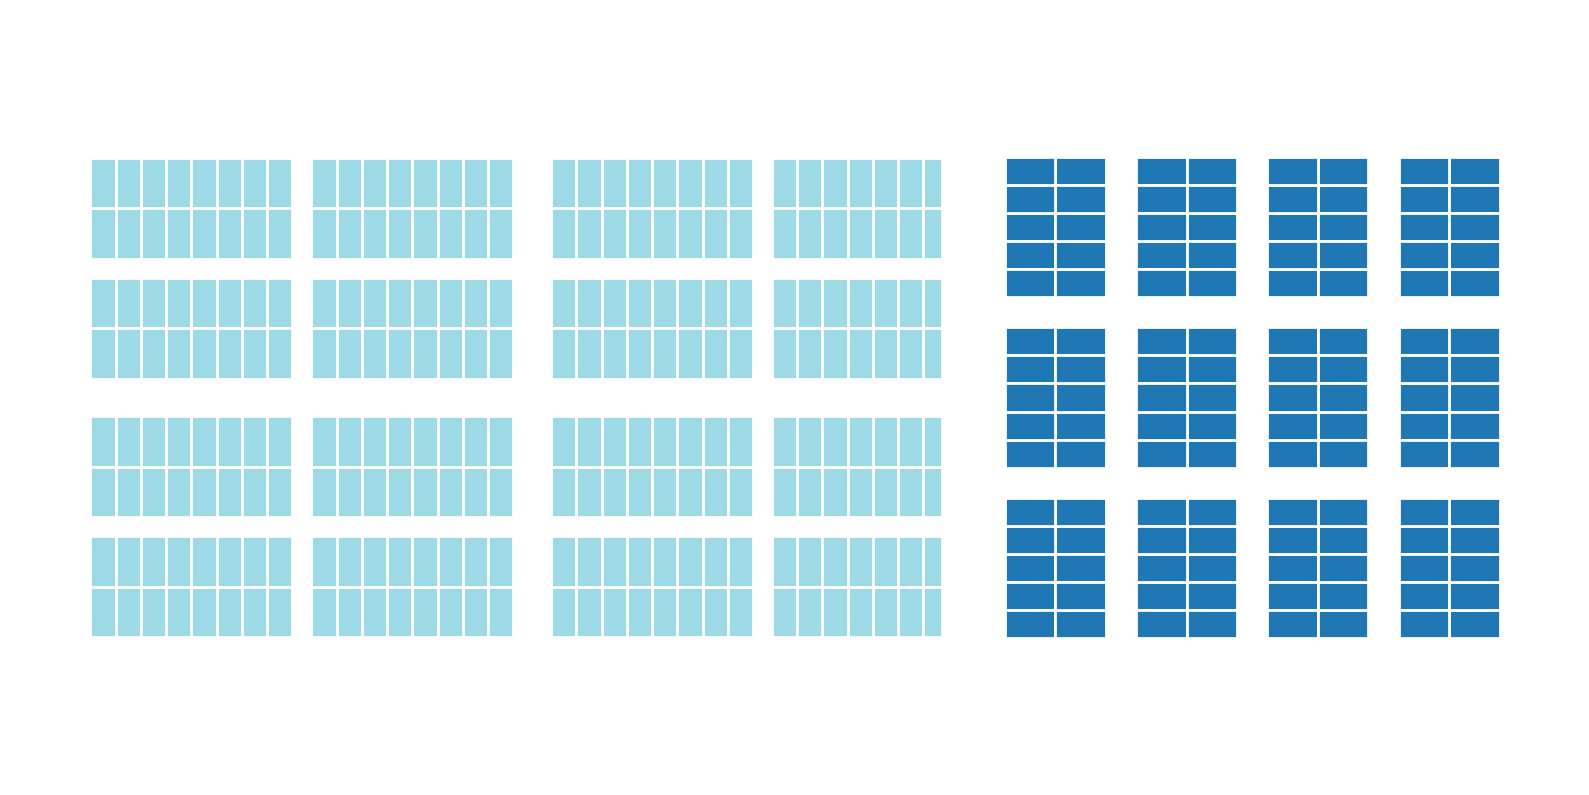

In [9]:
f, ax = plt.subplots(figsize=(10,5), dpi=200)
ax.axis('equal')
cmap = plt.cm.get_cmap('tab20')

plot_data = {'geometry': [], 'cluster_number': []}
for i, sc in enumerate(utils.get_exists_at(cluster, 48)):
    plot_data['geometry'].extend([parcel.polygon for parcel in sc.parcels])
    plot_data['cluster_number'].extend([i % 20] * len(sc.parcels))
gpd.GeoDataFrame(plot_data).plot(ax=ax, column='cluster_number', edgecolor='white', cmap='tab20')
ax.axis('off')

<AxesSubplot:>

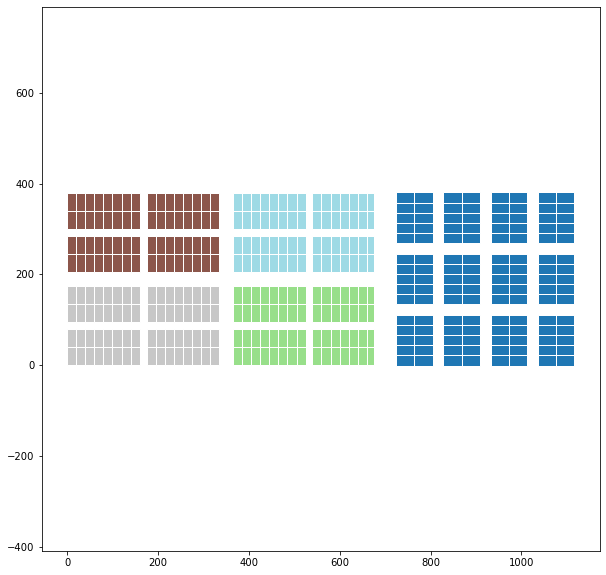

In [10]:
f, ax = plt.subplots(figsize=(10,10))
ax.axis('equal')
cmap = plt.cm.get_cmap('tab20')

plot_data = {'geometry': [], 'cluster_number': []}
for i, sc in enumerate(utils.get_exists_at(cluster, 29)):
    plot_data['geometry'].extend([parcel.polygon for parcel in sc.parcels])
    plot_data['cluster_number'].extend([i % 20] * len(sc.parcels))
gpd.GeoDataFrame(plot_data).plot(ax=ax, column='cluster_number', edgecolor='white', cmap='tab20')

<AxesSubplot:>

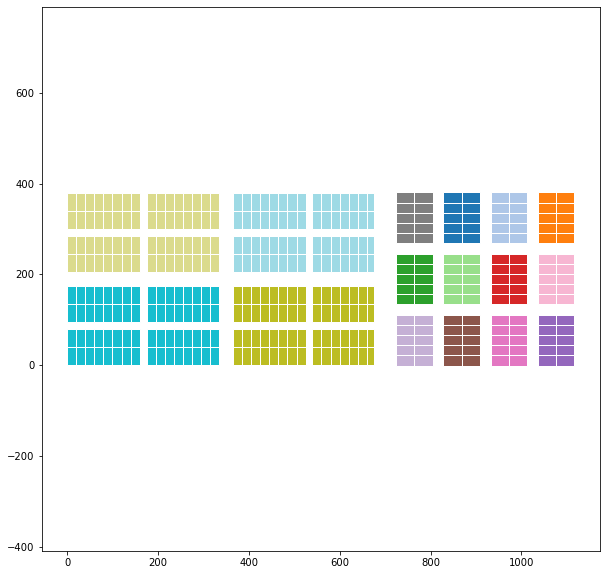

In [11]:
f, ax = plt.subplots(figsize=(10,10))
ax.axis('equal')
cmap = plt.cm.get_cmap('tab20')

plot_data = {'geometry': [], 'cluster_number': []}
for i, sc in enumerate(utils.get_exists_at(cluster, 23)):
    plot_data['geometry'].extend([parcel.polygon for parcel in sc.parcels])
    plot_data['cluster_number'].extend([i % 20] * len(sc.parcels))
gpd.GeoDataFrame(plot_data).plot(ax=ax, column='cluster_number', edgecolor='white', cmap='tab20')

<AxesSubplot:>

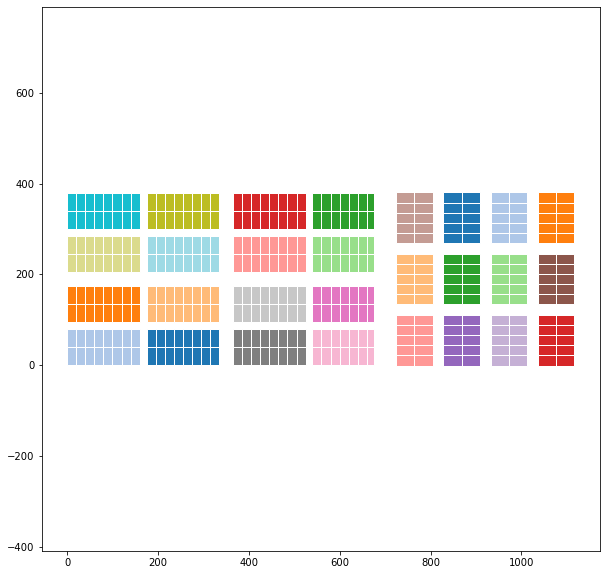

In [12]:
f, ax = plt.subplots(figsize=(10,10))
ax.axis('equal')
cmap = plt.cm.get_cmap('tab20')

plot_data = {'geometry': [], 'cluster_number': []}
for i, sc in enumerate(utils.get_exists_at(cluster, 14)):
    plot_data['geometry'].extend([parcel.polygon for parcel in sc.parcels])
    plot_data['cluster_number'].extend([i % 20] * len(sc.parcels))
gpd.GeoDataFrame(plot_data).plot(ax=ax, column='cluster_number', edgecolor='white', cmap='tab20')

/mnt/miscdata/repos/auto-urban-substructure-ident/utils/transitions.py:31: RuntimeWarning: invalid value encountered in true_divide
  transition_mat = transition_mat / transition_mat.sum(axis=1)[:, np.newaxis]


(1, 51)


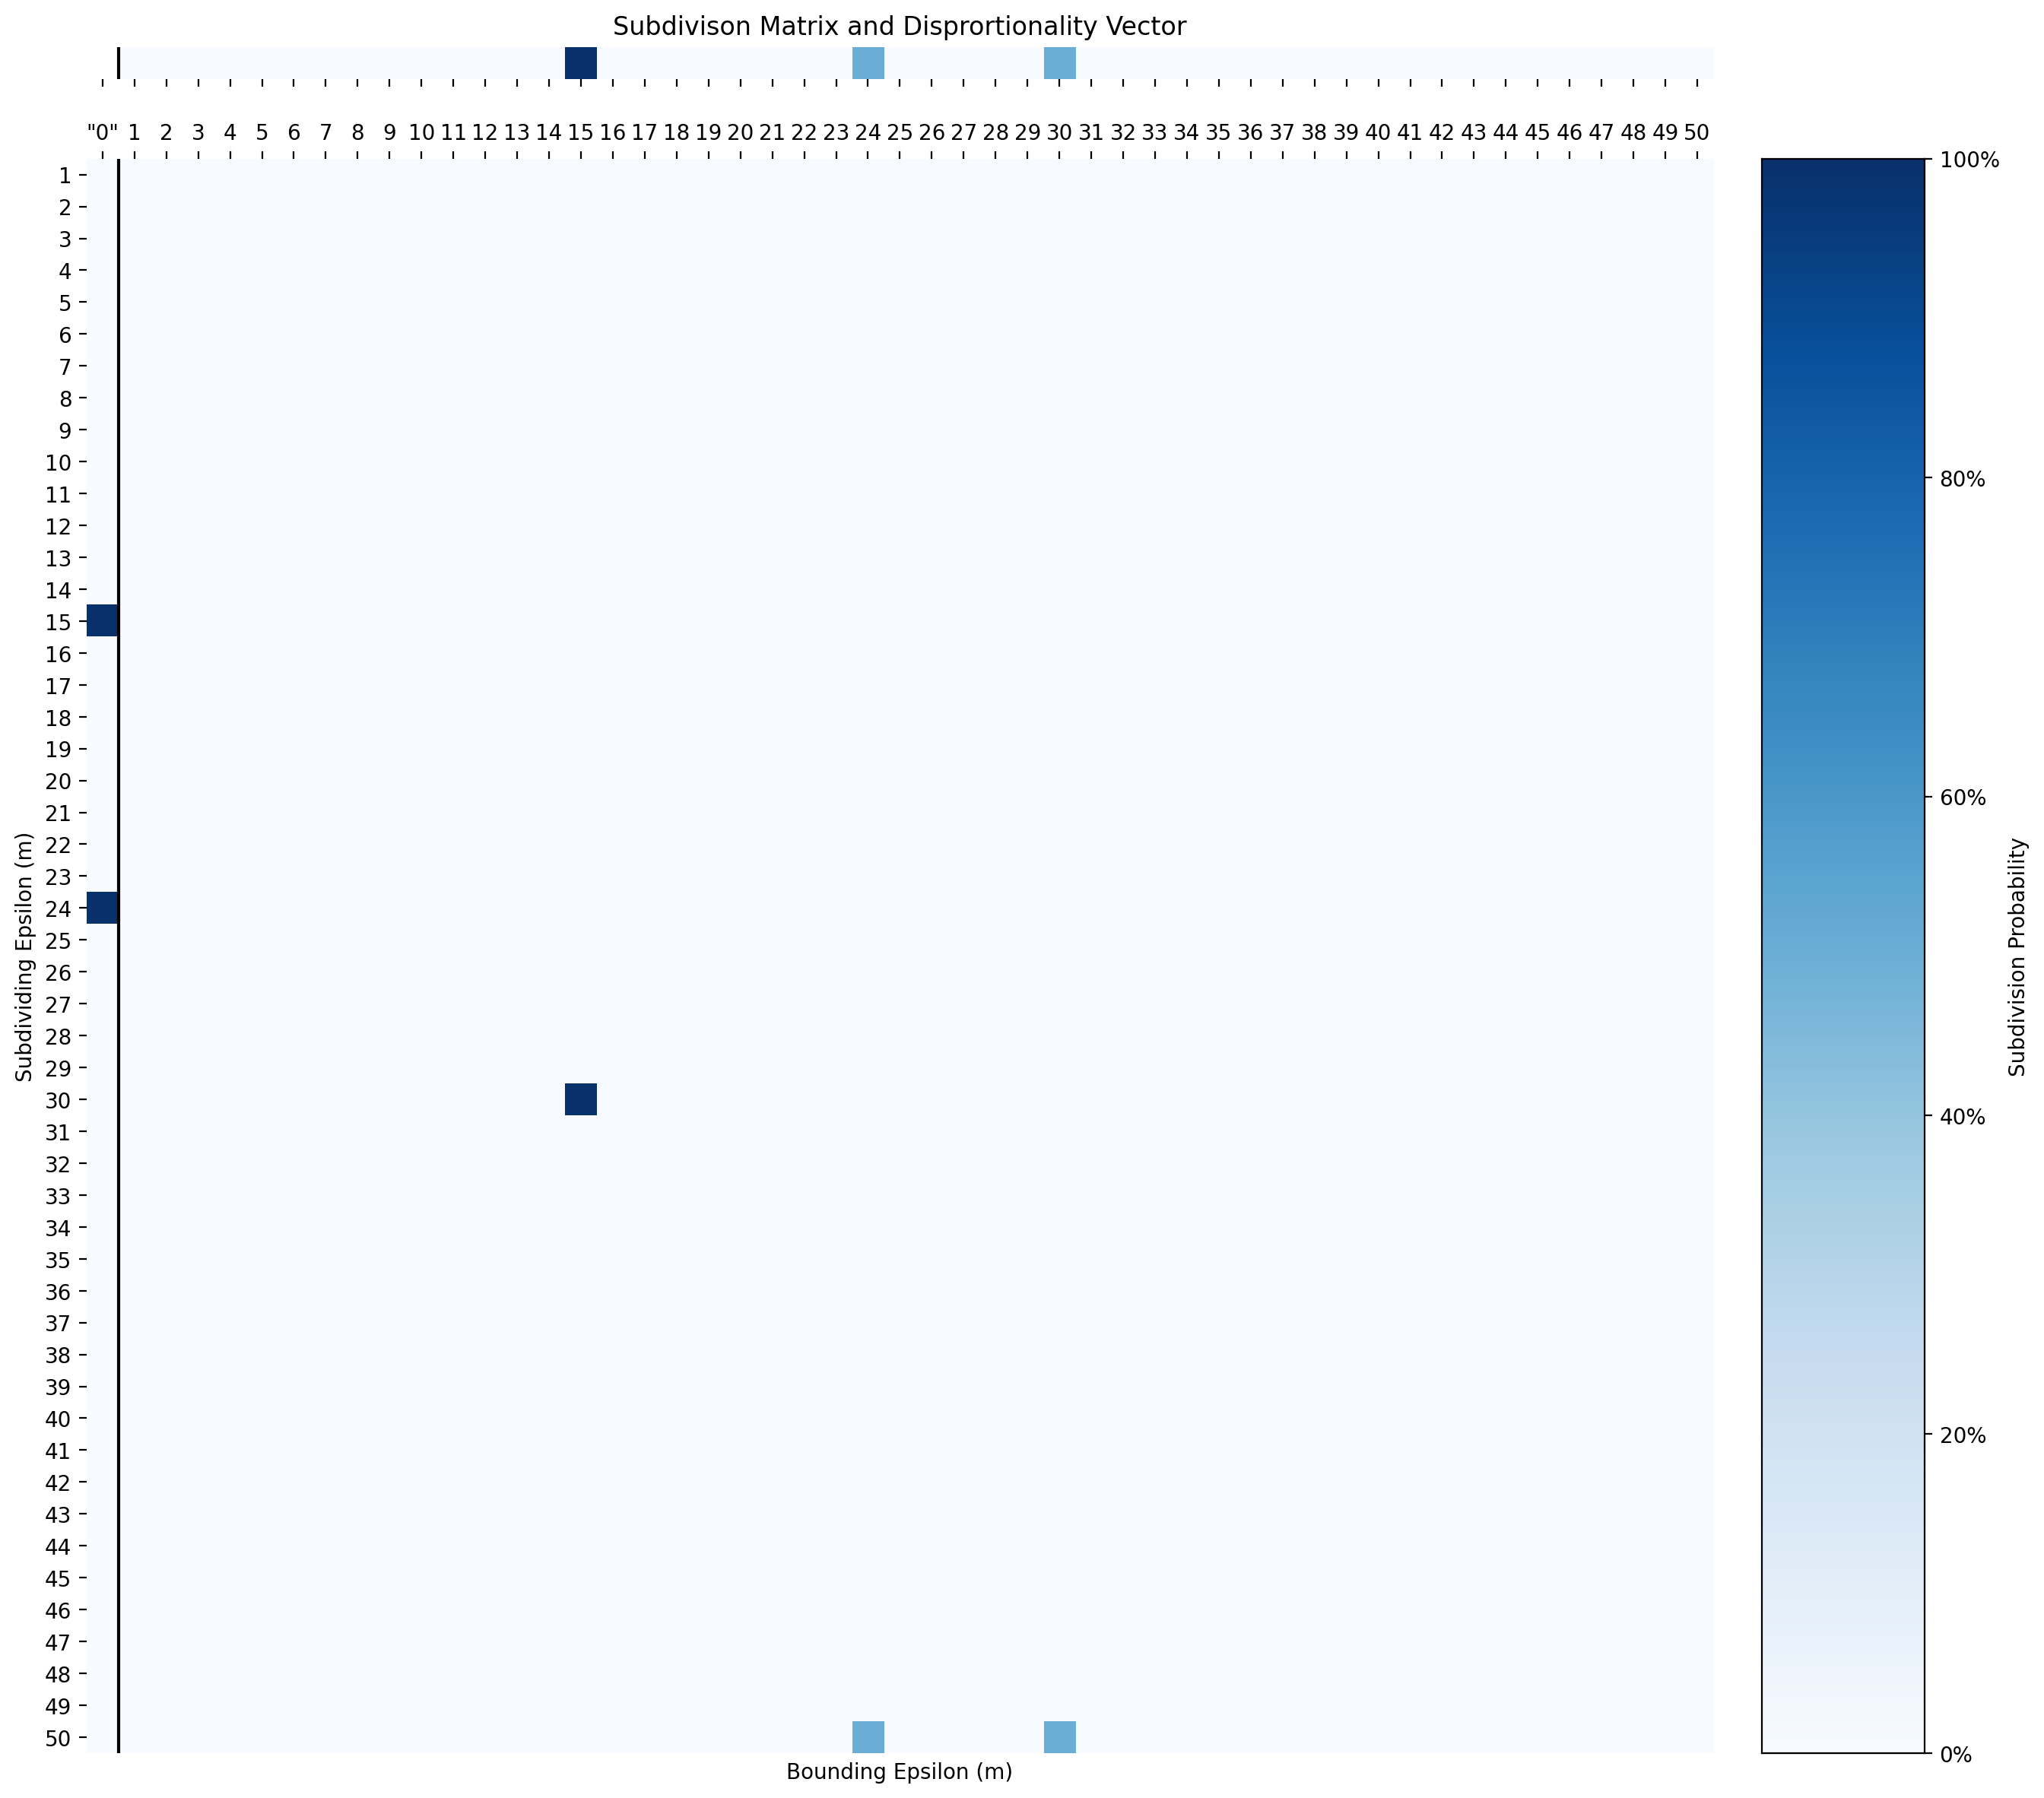

In [13]:
utils.plot_transitions(utils.desc_probs(cluster, normalize=0), firstok=1, maxdim=70)

## Synthetic City Analysis With Noise

0 1.0176405234596766 1
1 1 1.0040015720836721
2 1.0097873798410575 1
3 1 1.0224089319920147
0 1.0186755799014997 1
1 1 0.9902272212012359
2 1.009500884175256 1
3 1 0.998486427917023
0 0.9989678114820644 1
1 1 1.0041059850193836
2 1.0014404357116087 1
3 1 1.0145427350696297
0 1.00761037725147 1
1 1 1.0012167501649283
2 1.0044386323274543 1
3 1 1.0033367432737426
0 1.0149407907315762 1
1 1 0.997948417362342
2 1.003130677016509 1
3 1 0.9914590426069827
0 0.9744701018416592 1
1 1 1.0065361859544035
2 1.008644361988595 1
3 1 0.9925783497959356
0 1.022697546239876 1
1 1 0.9854563432540123
2 1.0004575851730144 1
3 1 0.9981281614997417
0 1.0153277921435846 1
1 1 1.0146935876990029
2 1.001549474256969 1
3 1 1.0037816251960217
0 0.9911221425236989 1
1 1 0.9801920353177608
2 0.9965208785067384 1
3 1 1.0015634896910397
0 1.0123029068072773 1
1 1 1.0120237984878442
2 0.9961267318259205 1
3 1 0.9969769724942467
0 0.989514470349329 1
1 1 0.9857998206282103
2 0.9829372980937499 1
3 1 1.019507753952317

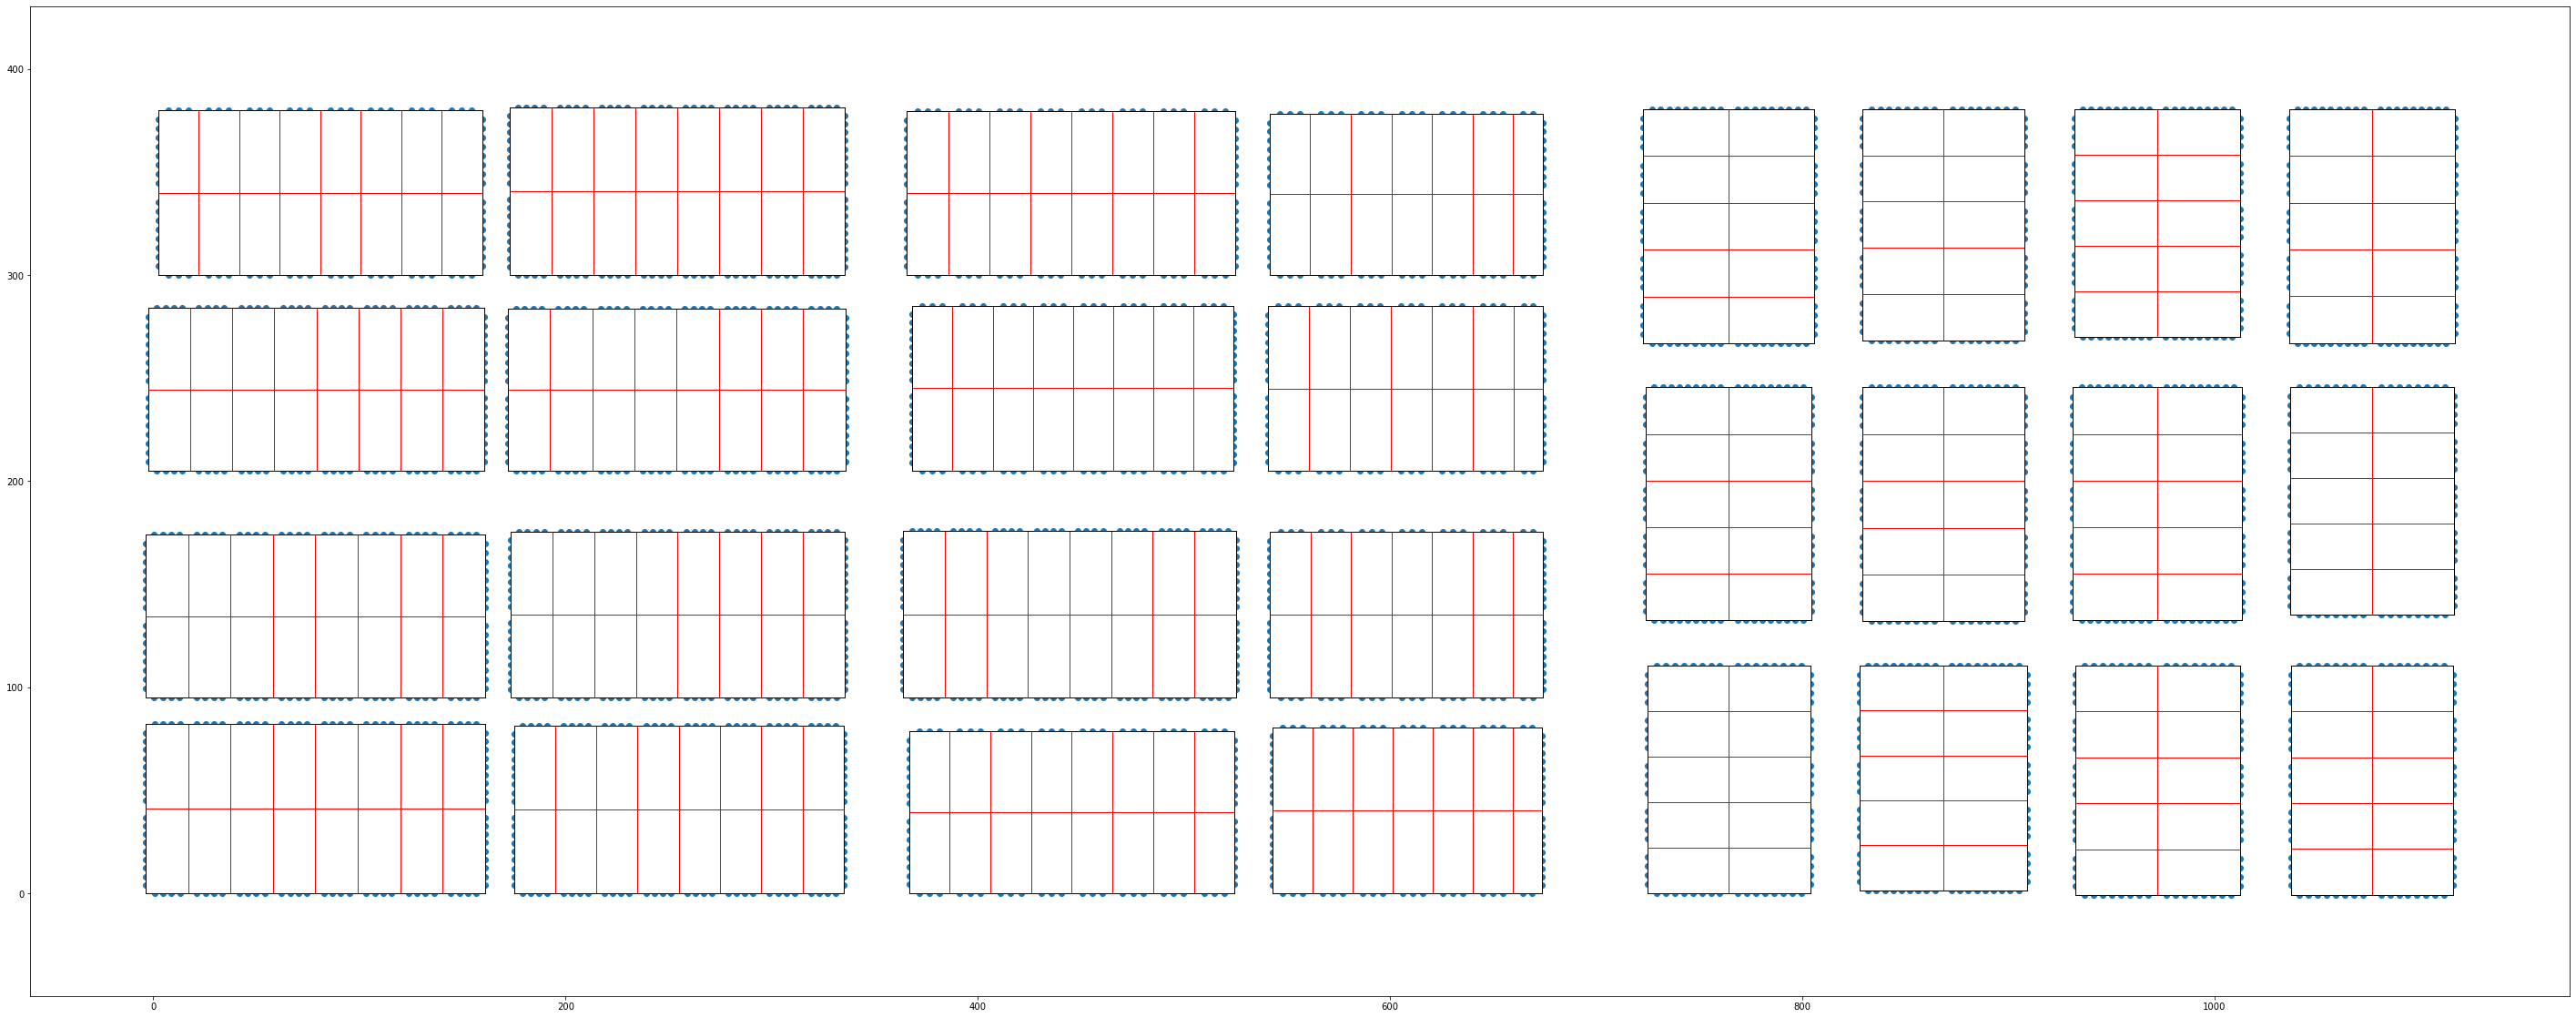

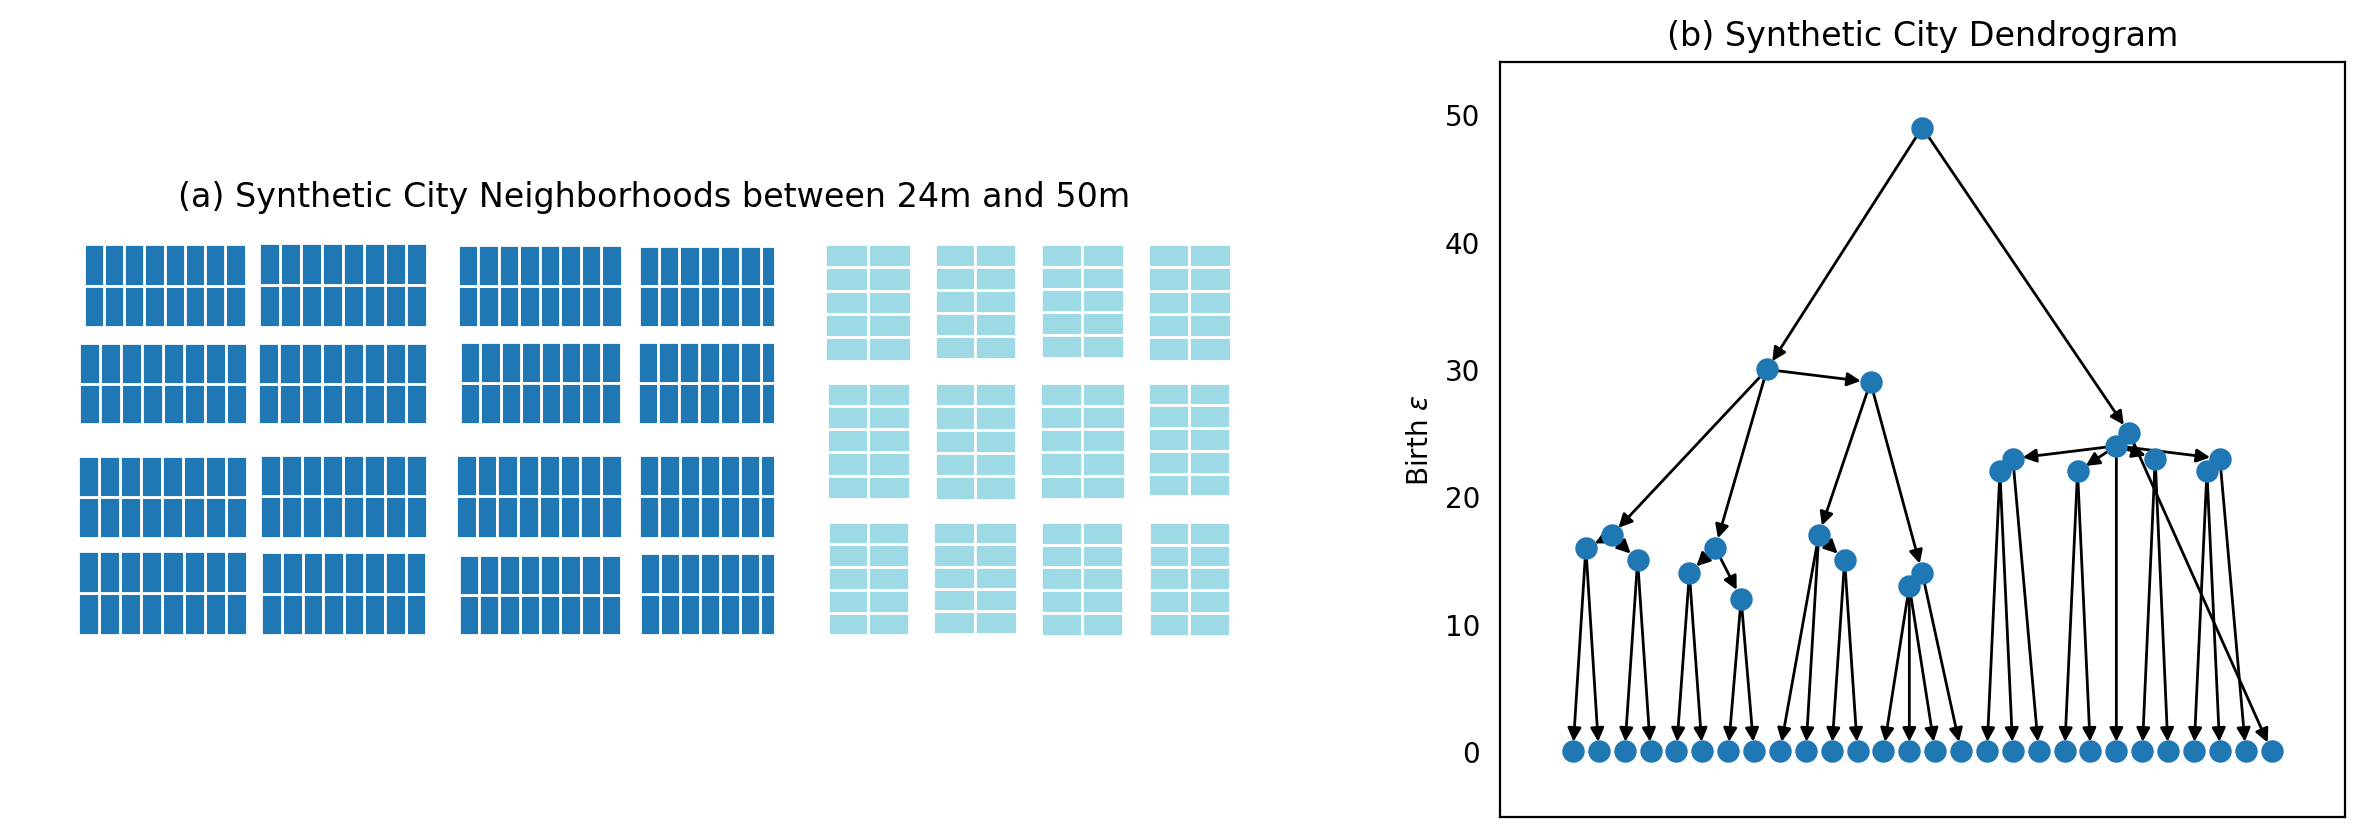

/mnt/miscdata/repos/auto-urban-substructure-ident/utils/transitions.py:31: RuntimeWarning: invalid value encountered in true_divide
  transition_mat = transition_mat / transition_mat.sum(axis=1)[:, np.newaxis]


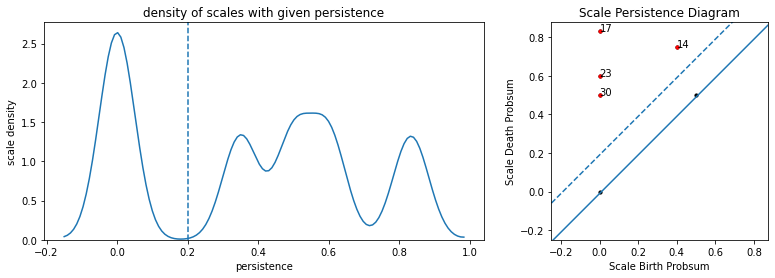

(1, 50)


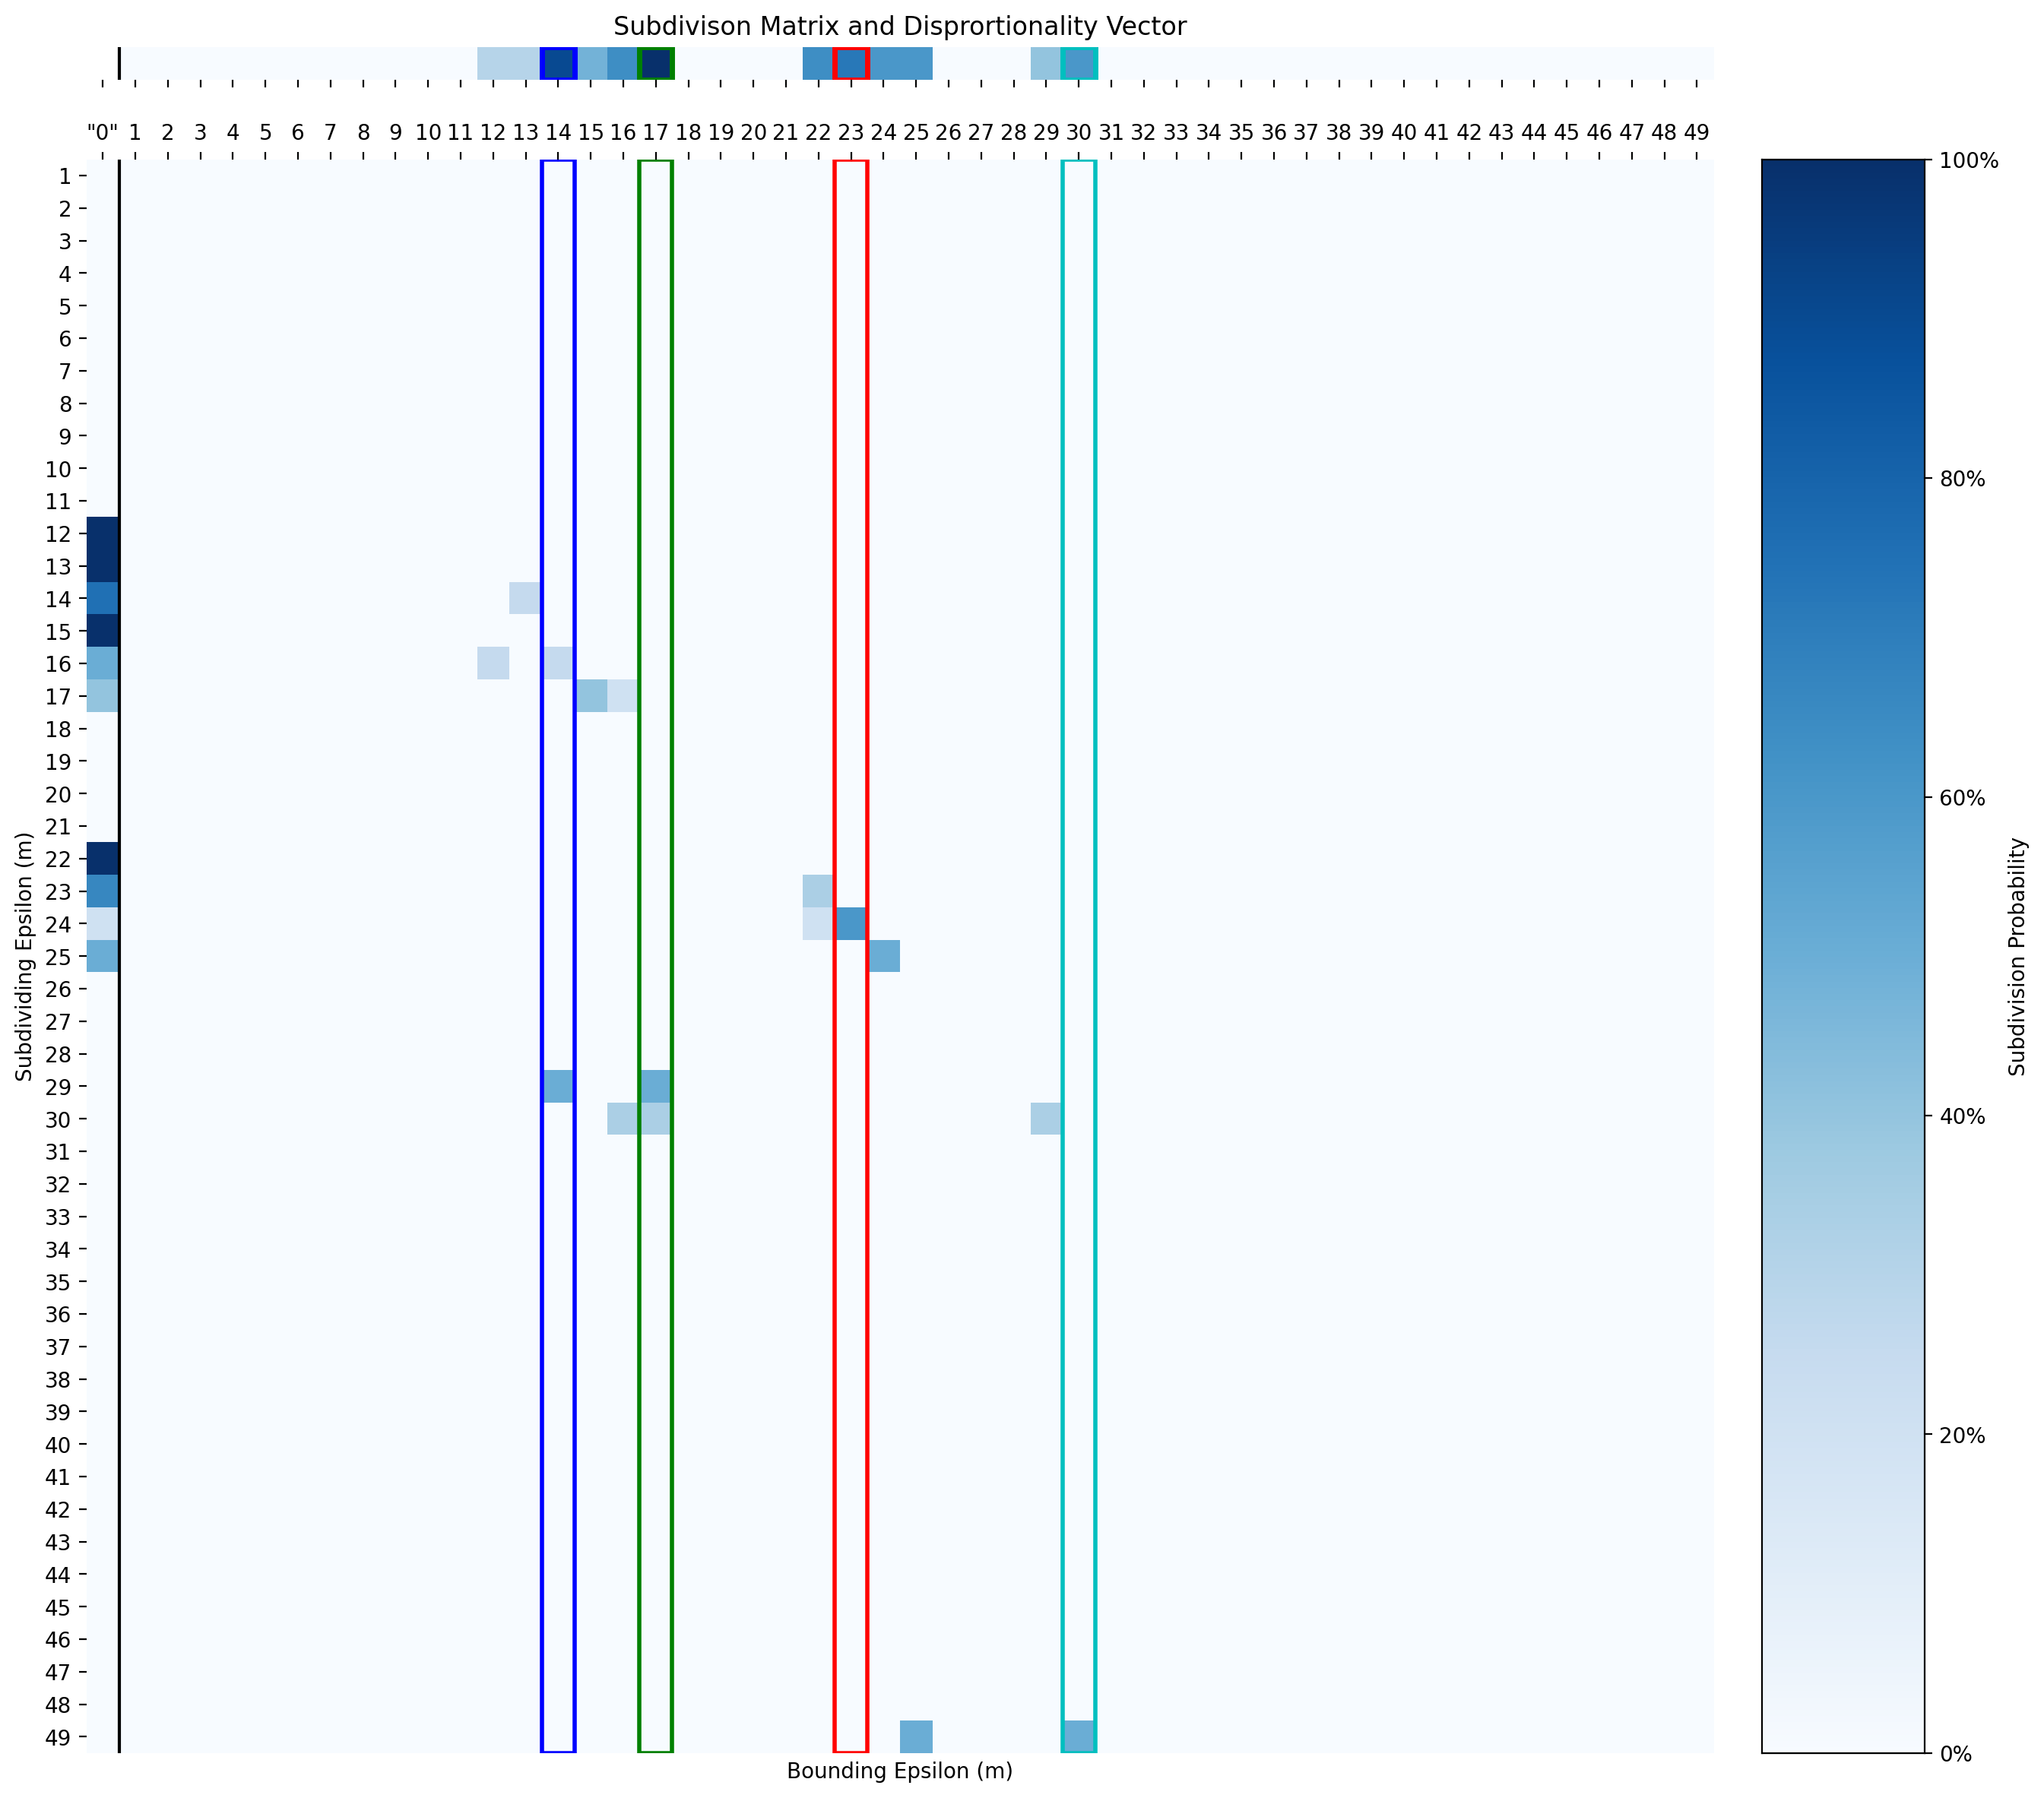

In [14]:
np.random.seed(0)
add_noise(mg, .01, True)

og.update()
# mg.update()

blocks = cascaded_union(mg.parcels)

parcel_objs = get_parcel_obj_list(pd.Series(list(mg.parcels)), blocks, None, min_dist=4)

f, ax = plt.subplots(figsize=(50, 20))
ax.axis('equal')
gpd.GeoSeries(parcel_objs.apply(lambda x: list(x[0])[0], axis=1)).plot(ax=ax)
gpd.GeoSeries(list(mg.parcels)).plot(ax=ax, color='white', edgecolor='red')
gpd.GeoDataFrame({'parcels': blocks}, geometry='parcels').plot(ax=ax, facecolor='none', edgecolor='black')

Z = utils.polygon_based.cluster_finder([p.polygon for p in parcel_objs.parcels])
cluster = utils.polygon_based.cluster_wrapper(Z, parcel_objs.parcels, discretize=True)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")

    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5), dpi=200, gridspec_kw={'width_ratios': [3, 2]})
    utils.plot_dendrogram(cluster, ax=ax2, node_color="tab:blue", width=1, node_size=50)
    ax2.set_title('(b) Synthetic City Dendrogram')
    
plot_data = {'geometry': [], 'cluster_number': []}
for i, sc in enumerate(utils.get_exists_at(cluster, 48)):
    plot_data['geometry'].extend([parcel.polygon for parcel in sc.parcels])
    plot_data['cluster_number'].extend([i % 20] * len(sc.parcels))
gpd.GeoDataFrame(plot_data).plot(ax=ax1, column='cluster_number', edgecolor='white', cmap='tab20')
ax1.set_title('(a) Synthetic City Neighborhoods between 24m and 50m')
ax1.axis('off')
plt.show()

transition_mat = utils.desc_probs(cluster, normalize=0)

highlights = sorted(utils.composite_persistence_plot(transition_mat, tau=.2).values())

utils.plot_transitions(transition_mat, firstok=1, maxdim=70, highlights=highlights)
plt.show()